# setup

In [6]:
import os
import uuid
from typing import Literal
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from langchain_community.agent_toolkits import SQLDatabaseToolkit

In [7]:
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
from langfuse import Langfuse
from langfuse.langchain import CallbackHandler

langfuse = Langfuse()
langfuse_handler = CallbackHandler()

In [9]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4o-mini")

# database setup

In [10]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


In [11]:
from langchain_community.utilities import SQLDatabase

db_path = "~/.cache/Chinook.db"
db_path = os.path.expanduser(db_path)

db = SQLDatabase.from_uri(f"sqlite:///{db_path}")

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM Artist LIMIT 5;")}')

Dialect: sqlite
Available tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Sample output: [(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


# agent setup

In [16]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [17]:
from langgraph.prebuilt import create_react_agent

system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect,
    top_k=5,
)

agent = create_react_agent(
    llm,
    tools,
    prompt=system_prompt,
)

# agent example

In [18]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_Bw4fHUPYQTyrkA4mblBkjiZ4)
 Call ID: call_Bw4fHUPYQTyrkA4mblBkjiZ4
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_VxMYWy8CkRSENoaUUmKlCo10)
 Call ID: call_VxMYWy8CkRSENoaUUmKlCo10
  Args:
    table_names: Track
  sql_db_schema (call_wNf6O9IofLGySgVNMiuiKDEW)
 Call ID: call_wNf6O9IofLGySgVNMiuiKDEW
  Args:
    table_names: Genre
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Genre" (
	"Genre

# Customized agent

In [12]:
generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)

check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)

In [13]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
sql_tools = toolkit.get_tools()

get_schema_tool = next(tool for tool in sql_tools if tool.name == "sql_db_schema")
run_query_tool = next(tool for tool in sql_tools if tool.name == "sql_db_query")
list_tables_tool = next(tool for tool in sql_tools if tool.name == "sql_db_list_tables")

get_schema_node = ToolNode([get_schema_tool], name="get_schema")
run_query_node = ToolNode([run_query_tool], name="run_query")

# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": f"call_{uuid.uuid4().hex}",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])
    print("call get schema...")
    print(response)

    return {"messages": [response]}


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}
    

def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"

In [14]:
builder = StateGraph(MessagesState)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema")
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query")

builder.add_edge(START, "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

sql_agent = builder.compile()

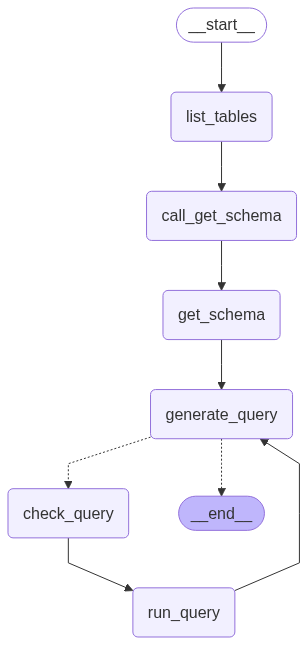

In [15]:
sql_agent

In [22]:
from langgraph.prebuilt import create_react_agent

In [23]:
create_react_agent()

TypeError: create_react_agent() missing 2 required positional arguments: 'model' and 'tools'

In [16]:
question = "Which genre on average has the longest tracks?"

for step in sql_agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
    config={"callbacks": [langfuse_handler]}
):
    step["messages"][-1].pretty_print()


================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================

Available tables: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
call get schema...
content='' additional_kwargs={'tool_calls': [{'id': 'call_w7YKICC5NWbHZMhnldgQCSvj', 'function': {'arguments': '{"table_names":"Genre, Track"}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 204, 'total_tokens': 222, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C8j1kXZzwmoCIvsuhnDH07xgnFXdK', 

In [21]:
step["messages"][-1].content

'The genre with the longest average track length is **Sci Fi & Fantasy**, averaging approximately **2911.83 seconds** (or about 48.7 minutes). Here are the top genres by average track length:\n\n1. Sci Fi & Fantasy: 2911783 ms (about 48.7 minutes)\n2. Science Fiction: 2625549 ms (about 43.8 minutes)\n3. Drama: 2575283 ms (about 42.6 minutes)\n4. TV Shows: 2145041 ms (about 35.7 minutes)\n5. Comedy: 1585263 ms (about 26.4 minutes)'